In [1]:
import torch.nn.functional as F
import torch

In [2]:
brown_txt = open('./makemore/brown.txt', 'r').read().replace("\n", "\n ")

In [3]:
print(brown_txt[:100])

The Fulton County Grand Jury said Friday an investigation 
 of Atlanta's recent primary election pro


In [4]:
from tokenization import BasicTokenizer

In [5]:
from collections import Counter

In [6]:
tokenizer = BasicTokenizer(do_lower_case=False)
tokenized_brown = tokenizer.tokenize(brown_txt)
print(len(tokenized_brown))

1222650


In [7]:
def replace_rare_words(words, min_frequency, replacement='<UNK>'):
    word_counts = Counter(words)
    for i in range(len(words)):
        if word_counts[words[i]] < min_frequency:
            words[i] = replacement
replace_rare_words(tokenized_brown,4)

In [8]:
stoi = {s:i for i, s in enumerate(sorted(list(set(tokenized_brown))))}  # map char to int
itos = {i:s for s, i in stoi.items()}        # map int to char
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [9]:
block_size = 4 # context length: how many characters do we take to predict the next one?
batch_size = 1 
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = torch.tensor(encode(tokenized_brown[:100] ))
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

     
    return x, y

x, y = get_batch('train')
      # 10%

In [10]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
    
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------

class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


Bigram Model

In [11]:
from torch import nn

In [12]:
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ' '.join([itos[i] for i in l]) # decoder: take a list of integers, output a string


In [13]:
vocab_size = len(itos)
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)

            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)

            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel(vocab_size)


In [14]:
xb, yb = get_batch('train')

In [15]:
logits, loss = model.forward(xb, yb)
print(logits.shape, loss)

torch.Size([4, 17796]) tensor(10.9198, grad_fn=<NllLossBackward0>)


In [16]:
import matplotlib.pyplot as plt

In [17]:
torch.log(torch.tensor([1/17796]))

tensor([-9.7867])

In [18]:
print(decode(xb[:1].tolist()[0]))

The jury further said


In [19]:
gen = model.generate(xb[:1], 100)
print(decode(gen.tolist()[0][16:]))

114 Rather crept pansies At birdied grease Tartuffe Gazette Achievement waving rack acrylic Malraux behaved furnishing prisoner condition reservoir commitment Emma drills Sheldon located boiling stealing leaf object raises lighted distinguished stairs Packard retail brightness pronoun mastered criminal materials old Had pennies soak cowhand puzzle therefrom sealed sophisticated lace inflation janitor Dreams fall ecumenical Alone adventures Meanwhile Plus Samuel manufacturers justify maneuvers envisioned Waco Regular parks coast subdued r aggression Initially confusion PHYSICAL warmly Langford acrylic intentionally briskly Let maintain Folly solder risks Post Upton compulsory spirited receivers


In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
batch_size = 1
lossi = []
for steps in range(100): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())
    print(loss.item())


10.690248489379883
10.167500495910645
10.57088565826416
9.918997764587402
9.898266792297363
9.95962142944336
10.129379272460938
10.234058380126953
10.495096206665039
10.081415176391602
10.883224487304688
9.614476203918457
10.122442245483398
10.424175262451172
10.419878959655762
9.955451011657715
9.695646286010742
10.468881607055664
10.076745986938477
9.447837829589844
10.696253776550293
10.781949996948242
10.285181045532227
9.755837440490723
9.94769287109375
10.198534965515137
10.118342399597168
9.98757266998291
10.300580978393555
9.901689529418945
9.864984512329102
10.113720893859863
10.59006404876709
9.42236328125
9.860981941223145
10.54560661315918
10.581930160522461
9.957159042358398
10.894366264343262
9.185182571411133
10.57634449005127
10.198643684387207
10.53973388671875
10.062347412109375
10.54749584197998
10.68259334564209
10.096710205078125
10.4705810546875
10.451343536376953
10.100602149963379
9.932037353515625
10.156679153442383
9.782207489013672
10.883878707885742
9.947929

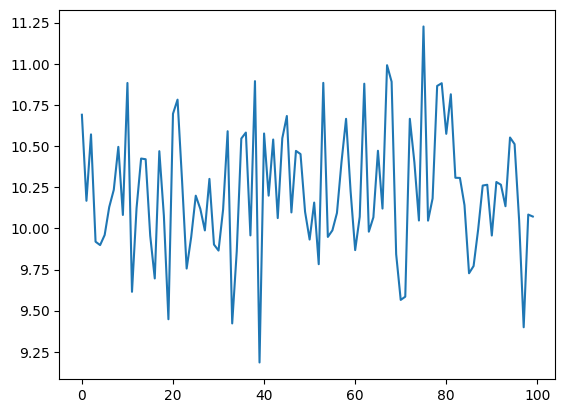

In [29]:
plt.plot(lossi)

In [21]:
print("a")

a
